In [23]:
from plot_functions import concept_gradient_importance
from gnnNets import *
from dataset import get_dataset, get_dataloader
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import os

In [8]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="config", job_name="test_app")
cfg = compose(config_name="config", overrides=[])
print(OmegaConf.to_yaml(cfg))
config = cfg

models:
  gnn_saving_dir: ''
  gnn_name: gat
  n_heads: 3
  param:
    clintox:
      learning_rate: 0.0005
      weight_decay: 0.0005
      milestones: None
      gamma: None
      batch_size: 64
      num_epochs: 200
      num_early_stop: 0
      gnn_latent_dim:
      - 64
      - 64
      - 64
      gnn_dropout: 0.0
      add_self_loop: true
      gcn_adj_normalization: false
      gnn_emb_normalization: false
      graph_classification: true
      node_classification: false
      gnn_nonlinear: sigmoid
      readout: sum
      fc_latent_dim:
      - 128
      fc_dropout: 0.0
      fc_nonlinear: elu
    tox21:
      learning_rate: 0.001
      weight_decay: 0.0005
      milestones: None
      gamma: None
      batch_size: 64
      num_epochs: 200
      num_early_stop: 20
      gnn_latent_dim:
      - 128
      - 128
      - 128
      gnn_dropout: 0.0
      add_self_loop: true
      gcn_adj_normalization: true
      gnn_emb_normalization: false
      graph_classification: true
      n

In [9]:
config.models.gnn_saving_dir = 'gnn_checkpoints'
config.models.param = config.models.param[config.datasets.dataset_name]

if torch.cuda.is_available():
    device = torch.device('cuda', index=config.device_id)
else:
    device = torch.device('cpu')

dataset = get_dataset(dataset_root=config.datasets.dataset_root,
                      dataset_name=config.datasets.dataset_name)
dataset.data.x = dataset.data.x.float()
dataset.data.y = dataset.data.y.squeeze().long()
if config.models.param.graph_classification:
    dataloader_params = {'batch_size': 1,
                         'stratified': config.stratified,
                         'random_split_flag': config.datasets.random_split_flag,
                         'data_split_ratio': config.datasets.data_split_ratio,
                         'seed': config.datasets.seed}

In [10]:
dataset = get_dataset(dataset_root=config.datasets.dataset_root,
                          dataset_name=config.datasets.dataset_name)

dataloader = get_dataloader(dataset, **dataloader_params)

In [11]:
model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models, config.concept_whitening, concept_acts=True)
model.replace_norm_layers()

saved = torch.load(f"/home/michelaproietti/ConceptWhitening_GNNs/trained_models/bbbp/{config.models.gnn_name}_cw_max.pth")
state_dict = saved['net']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
plot_dst = os.path.join(config.base_dir, 'plot/')

if not os.path.exists(plot_dst):
    os.mkdir(plot_dst)

In [16]:
layers_importance = []
layers_importance.append(concept_gradient_importance(config, dataloader['test'], 0))
layers_importance.append(concept_gradient_importance(config, dataloader['test'], 1))
layers_importance.append(concept_gradient_importance(config, dataloader['test'], 2))

Loading model: /home/michelaproietti/thesis_last/trained_models/bbbp/gat_cw_max.pth


/home/michelaproietti/ConceptWhitening_GNNs/iterative_normalization.py:82: UserWarning: This overload of baddbmm is deprecated:
	baddbmm(Number beta, Tensor input, Number alpha, Tensor batch1, Tensor batch2, *, Tensor out)
Consider using one of the following signatures instead:
	baddbmm(Tensor input, Tensor batch1, Tensor batch2, *, Number beta, Number alpha, Tensor out) (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/python_arg_parser.cpp:1055.)
  Sigma = torch.baddbmm(eps, P[0], 1. / m, xc, xc.transpose(1, 2)) # In the paper: 1/n *(Z-mu*1^T)(Z-mu*1^T)^T
/home/michelaproietti/.conda/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-fu

[0.48 0.48 0.38 0.34 0.34]
Loading model: /home/michelaproietti/thesis_last/trained_models/bbbp/gat_cw_max.pth


/home/michelaproietti/.conda/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


[0.4  0.42 0.42 0.66 0.62]
Loading model: /home/michelaproietti/thesis_last/trained_models/bbbp/gat_cw_max.pth


/home/michelaproietti/.conda/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


[0.3  0.84 0.94 0.52 0.28]


In [17]:
concepts = ['qed','tpsa','logp','NOCount','n_heteroatoms']

In [18]:
layers = [f'Layer {i}' for i in range(3)]

In [19]:
vals = np.array(layers_importance)

nconcepts = len(concepts)
nlayers = len(layers)

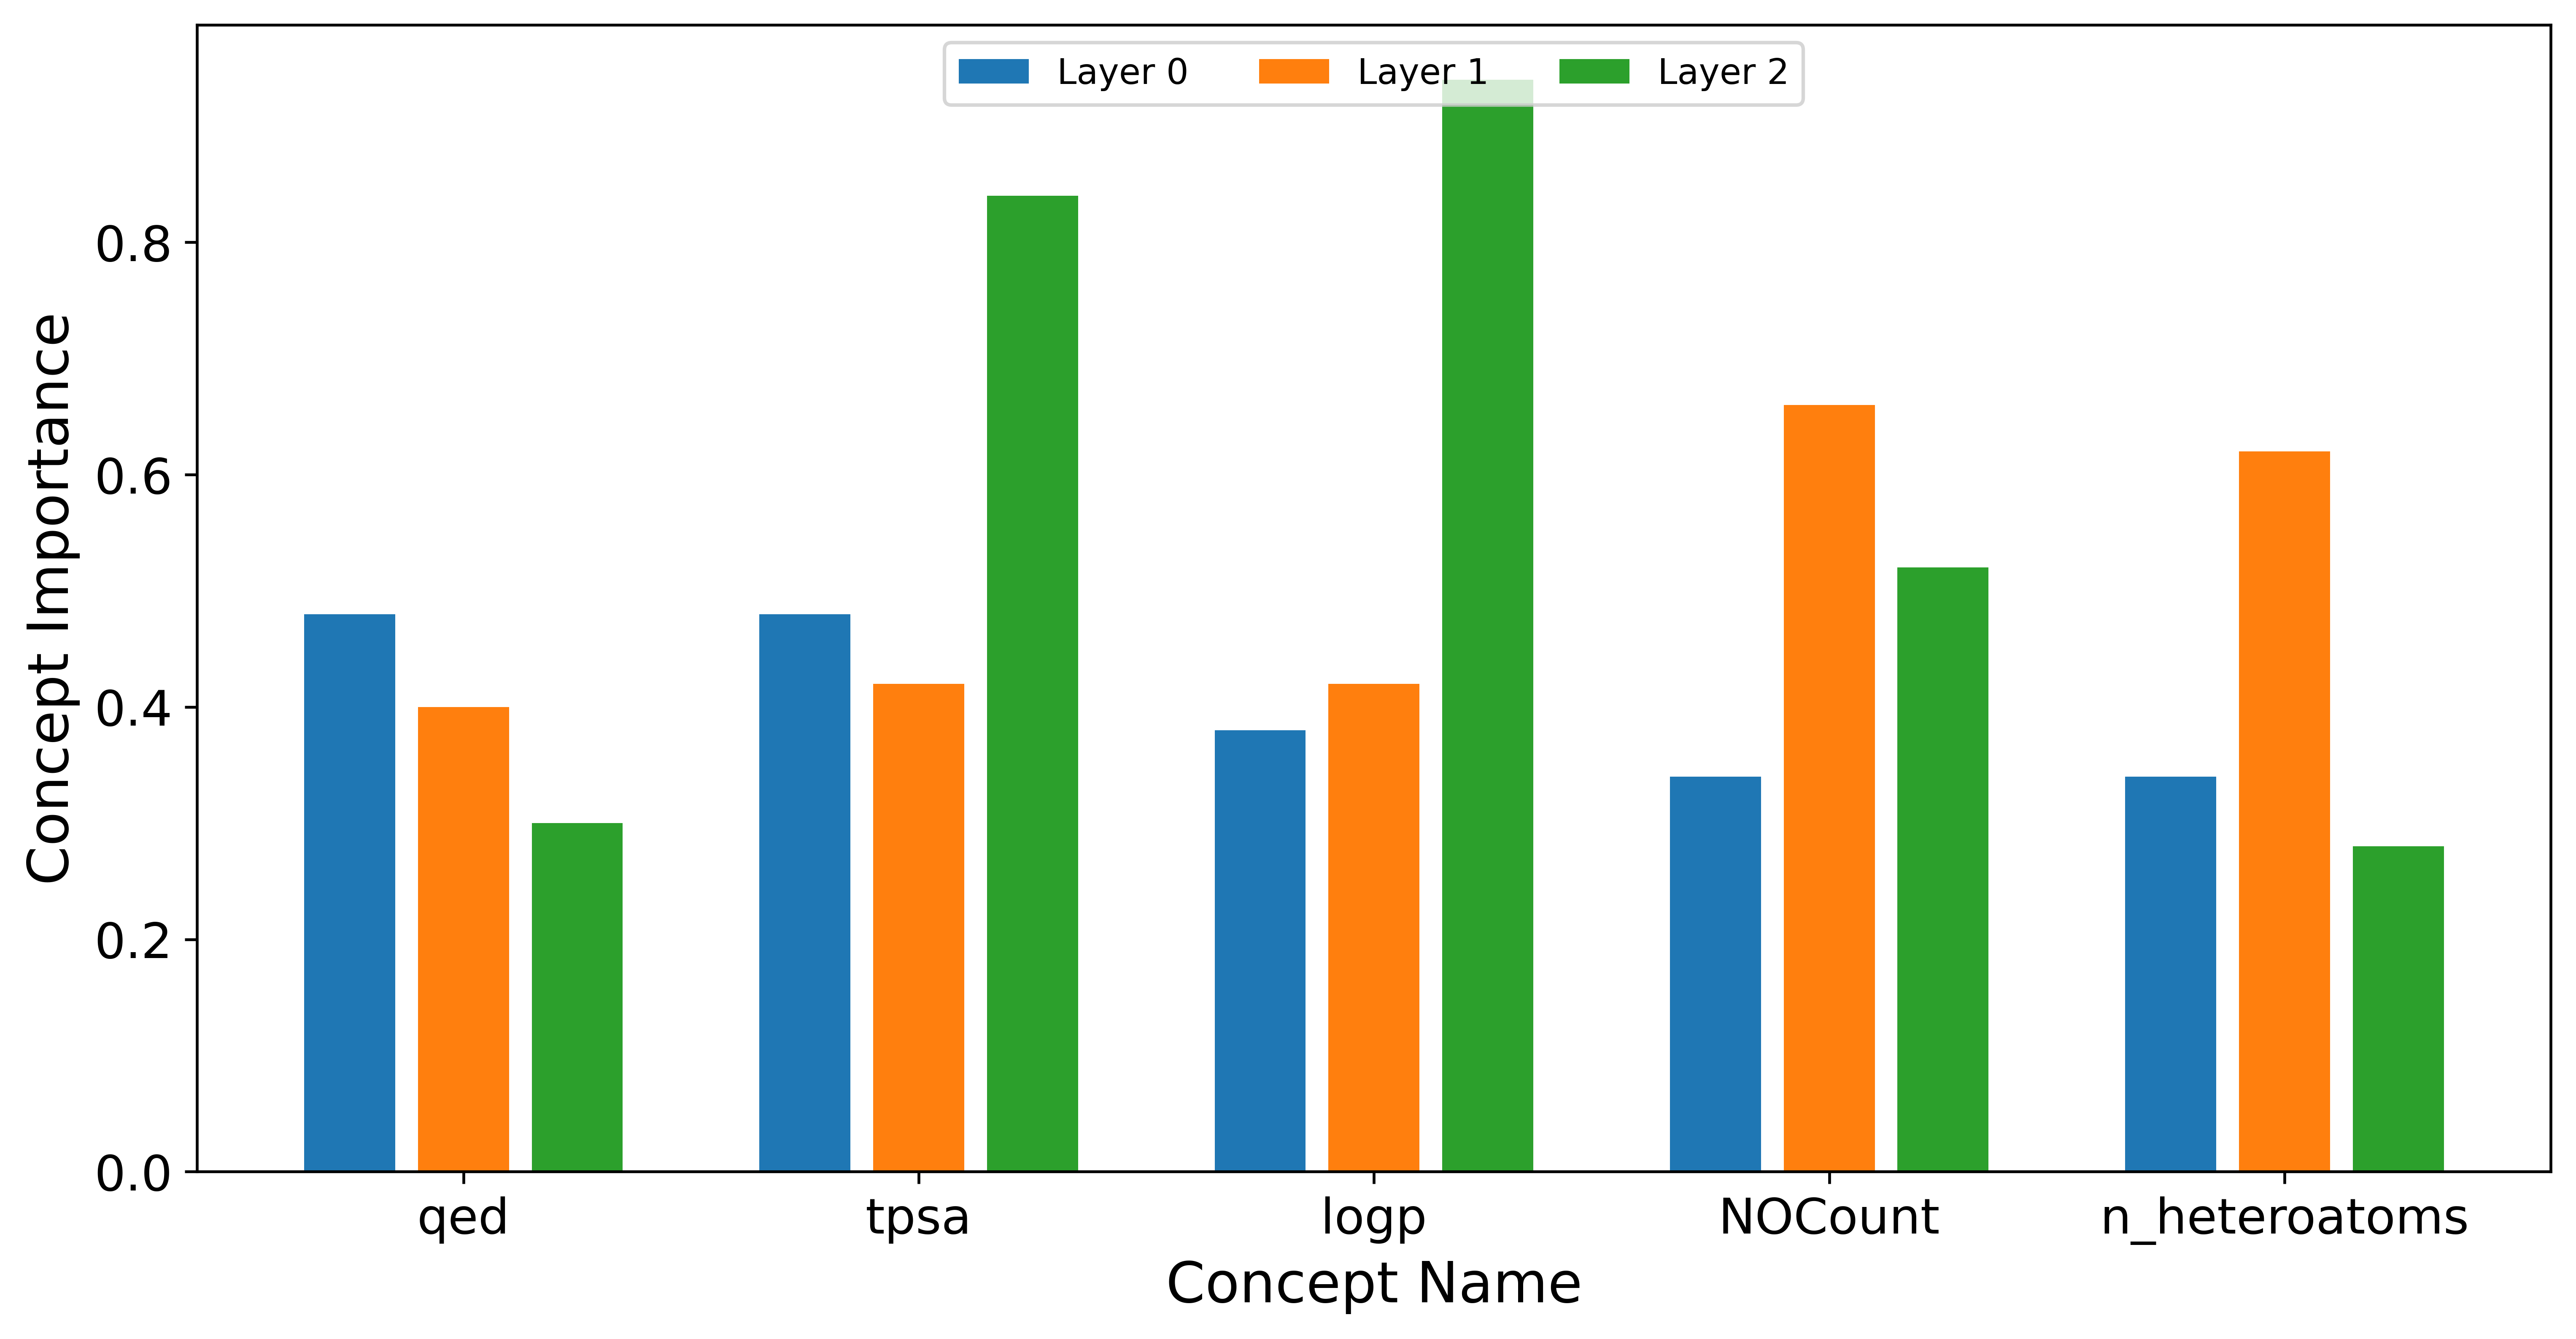

In [24]:
fig = plt.figure(figsize=(12,6), dpi=600)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
delta = 0.25

for il, layer in enumerate(layers):
    plt.bar([i+il*delta for i in range(nconcepts)], vals[il], width=0.2)

plt.ylabel('Concept Importance', fontsize=16)
plt.xlabel('Concept Name', fontsize=16)
plt.xticks([i+delta for i in range(nconcepts)], concepts)
plt.legend(layers, loc="upper center", ncol=3)
plt.savefig(plot_dst+'/concepts_importance.jpg')

(-0.5, 14399.5, 7199.5, -0.5)

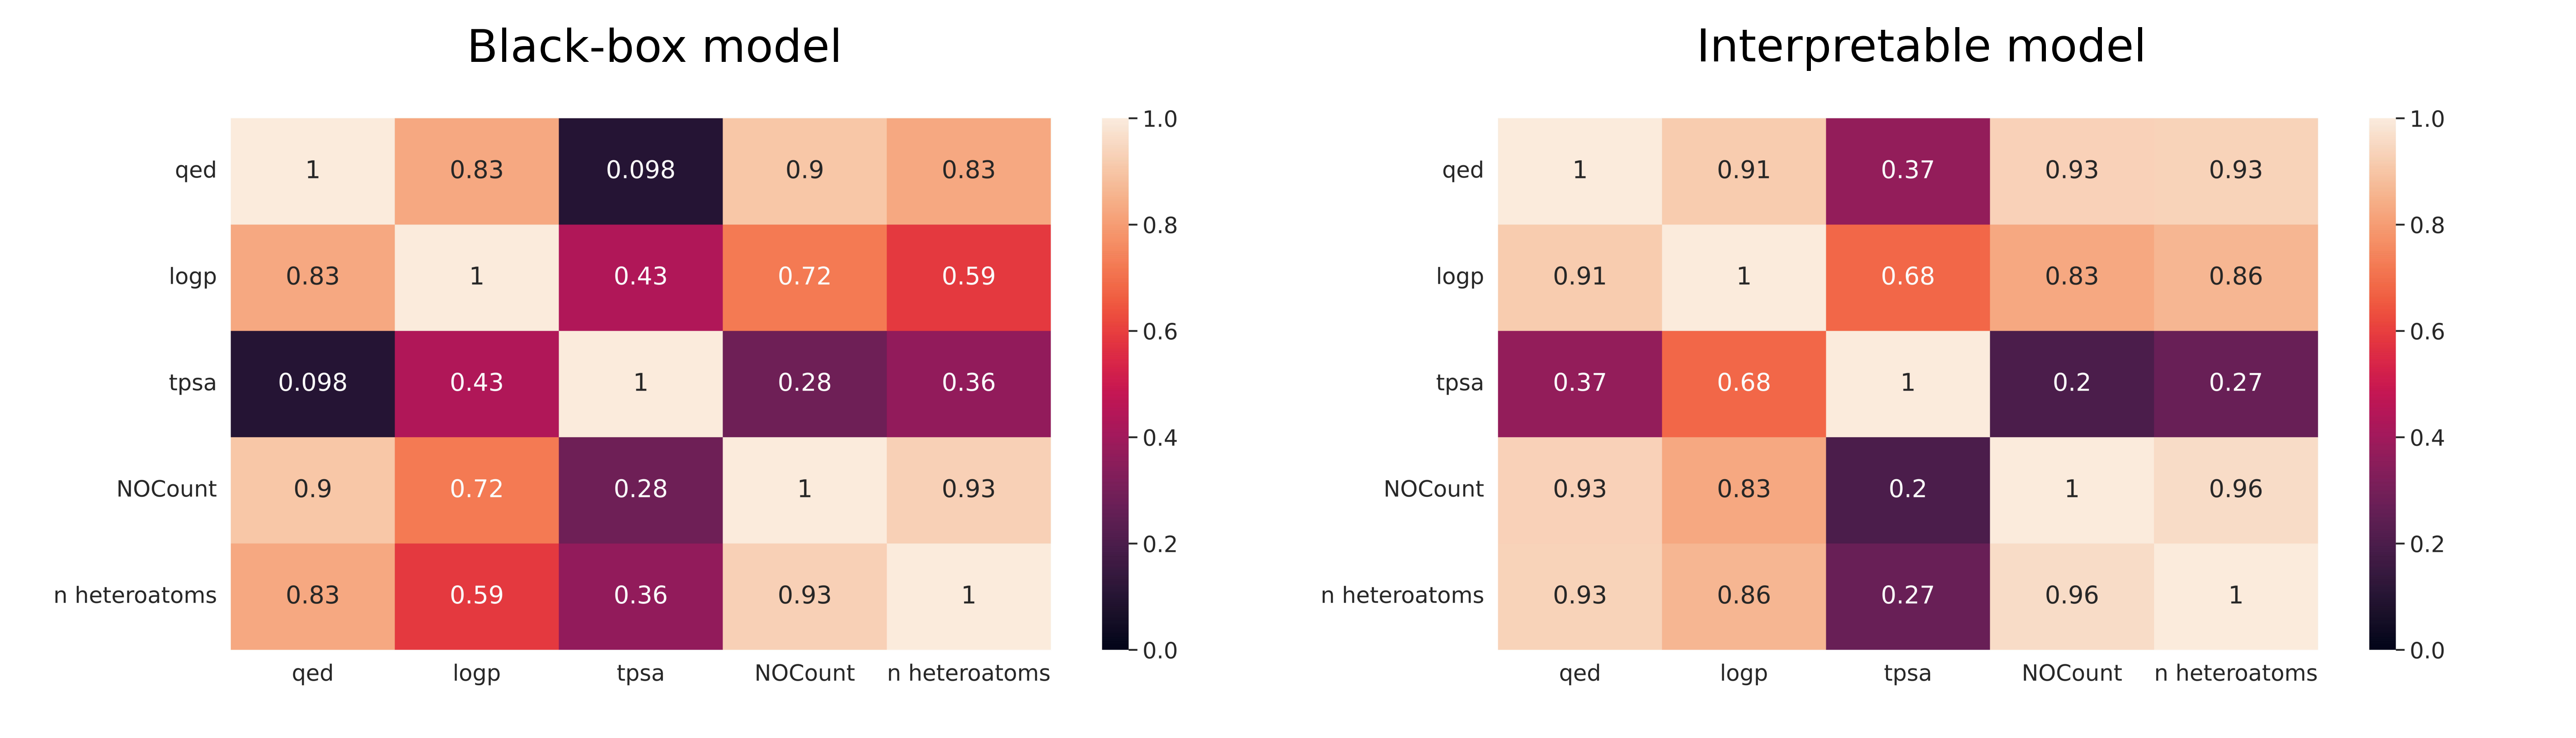

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img1 = Image.open('/home/michelaproietti/ConceptWhitening_GNNs/plot/qed_logp_tpsa_NOCount_n_heteroatoms/inner_product/_False_2.jpg')
img2 = Image.open('/home/michelaproietti/ConceptWhitening_GNNs/plot/qed_logp_tpsa_NOCount_n_heteroatoms/inner_product/_True_2.jpg')


#define subplots
fig = plt.figure(figsize=(12,6), dpi=600)
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.01)
ax = gs.subplots(sharex='col', sharey='row')

#define subplot titles
ax[0].set_title('Black-box model', fontsize=12)
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].set_title('Interpretable model', fontsize=12)
ax[1].imshow(img2)
ax[1].axis('off')